# Group Project: Pulsar Star Data 

## 0  Introduction 

#### 0.1  What are Pulsar Stars:

Pulsar stars are a very rare type of neutron star that produce radio emission detectable on Earth. As pulsar stars rotate rapidly and their emission beam sweeps across the sky, it produces a detectable pattern of repeating radio emission. Pulsar stars can be looked for through large radio telescopes.
 

#### 0.2  Insight into the HTRU2 Dataset: 

The HTRU2 dataset contains data about pulsars, both examples caused by RFI and/or noise, and real pulsar examples (noise is other radio signals also picked up thru pulsar star detection). The dataset contains a total of 17,898 samples of radio signals. This is an imbalanced dataset: 1,639 are real pulsar wave patterns while 16,259 are non-pulsar signals. Each pulsar star candidate is described by 8 continuous variables, and a single class variable.

The first four columns are simple statistics obtained from the integrated pulse profile, an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency. The remaining four variables are similarly obtained from the DM-SNR curve, a Dispersion Measure - Signal-to-Noise Ratio curve that is obtained through the pulsar star signal. The 8 variables are as such:

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.

Each row lists the variables first, and the class label is the final entry. The class labels used are 0 (non-pulsar) and 1 (pulsar).

#### 0.3  Predictor reasoning 
 
As proposed in R. J. Lyon’s thesis, “Why Are Pulsars Hard To Find?”, candidate/sample numbers in the pulsar dataset rise exponentially, and majority of those are attributable to noise. The 8 variables given in the HTRU2 dataset were formed from a secondary analysis due to the fact that the original variables collected exhibit characteristics of imbalance, such as class inseparability, and thus were relatively poor separators of pulsar and non-pulsar samples.

New variables (integrated pulse profile, DM-SNR curve) were designed so that they could maximize the separation between noise and non-noise candidates. Potential features were evaluated according to how well they each separated noise and non-noise candidates and the ability of each to reject noise was considered statistically. Those achieving the best separation, and the best classification results when used together with machine learning classifiers were then selected. **As such, all 8 of the variables of the integrated profile and the DM-SNR curve variables are important and must be used in our analysis.**
 

#### 0.4  Question:

Using the HTRU2 dataset, we aim to build a classification model that can reliably classify whether a data point is a pulsar star or not.

## 1  Methods:
For our proposal, we'll aim to build a classification system using the __K-nearest neighbours algorithm__. In the following code, we'll load our data, clean it and set up the foundations for our model to be built on.

Since R uses randomness for many of it's data training functions, and we want our work to be reproducible, we can use `set.seed()` so R continues to use the same sequences of randomness.

In [159]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 10)

In [160]:
set.seed(77)

Our data is hosted on the UCI Machine Learing Repository in a compressed format, so we'll need to download and decompress the data using the `download.file()` and `unz()` functions respectively. Past that, we can use our standard `read_csv()` function with `col_names = FALSE` to indicate that our data does not include column names.

We can manually fetch, abbreviate and `rename()` the column names from the data's associated `Readme.txt` file and apply them to our data with the `rename()` function. We also `mutate()` our status column to a factor for future use in classification functions.

In [161]:
# Create a temp. file name (eg tempfile())
temp <- tempfile()       # declaring a temporary file

# Use download.file() to fetch the file into the temp. file
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip", temp)

# Use unz() to extract HRTU_2.csv from temp. file
conn <- unz(temp, "HTRU_2.csv")
data <- read_csv(conn, col_names = FALSE)

# Remove the temp file via unlink()
unlink(temp)             # scrapping our temporary file
data <- rename(data,
               mean = X1,
               st_dev = X2,
               e_kurtosis = X3,
               skewness = X4,
               snr_mean = X5,
               snr_st_dev = X6,
               snr_e_kurtosis = X7,
               snr_skewness = X8,
               status = X9) |>
    mutate(status = as_factor(status))
data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean,st_dev,e_kurtosis,skewness,snr_mean,snr_st_dev,snr_e_kurtosis,snr_skewness,status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022,0
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,0
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0


To ensure that all our observations have a complete set of predictors, we should check our tibble for missing values. If we find any, they should be removed so our classification model is not working on incomplete data.

In [162]:
missing_vals <- sum(is.na(data))
missing_vals

[1] 0

All our rows are complete! We can continue without removing any observations.

Having completed our loading and cleaning, we should now split our data into a training set and a testing set. `data_train` will serve as the basis for training our classification model, and `data_test` will be set aside entirely until we are done building. This allows for a fair assessment of the accuracy of our model, since we will be testing it against observations that it has never seen before.

We can achieve this by using the `initial_split()` function (and our reproducible randomness!).

In [163]:
data_split <- initial_split(data, prop = 0.75, strata = status)
data_train <- training(data_split)
data_test <- testing(data_split)

In [164]:
# describe what class bias means
# here we are counting the data points in each class to decide whether we need to correct for class bias


In [165]:
counts <- data_train |>
    group_by(status) |>
    summarize(n=n())

counts

status,n
<fct>,<int>
0,12196
1,1227


In [166]:
# There are many more non pulsars than pulsars
# we will upsample to correct for class bias and balance the data

In [167]:
library(caret)
data_balanced <- upSample(x = data_train[, -ncol(data_train)] , y = data_train$status, yname = "status")
data_balanced
counts_balanced <- data_balanced |>
    group_by(status) |>
    summarize(n = n())

counts_balanced

mean,st_dev,e_kurtosis,skewness,snr_mean,snr_st_dev,snr_e_kurtosis,snr_skewness,status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
71.41406,40.51900,1.5822779,4.229061893,8.204849,39.56497,5.1943521,26.0929235,1
65.93750,35.33981,2.7720948,11.648524440,15.684783,43.57831,3.5071074,12.8557791,1
85.56250,62.43181,0.9340457,0.007399074,156.728261,93.78110,-0.6489241,-1.2136441,1


status,n
<fct>,<int>
0,12196
1,12196


To demonstrate the effect of oversampling, we can plot graphs for the `mean` vs. `st_dev` using both the unbalanced and balanced data.

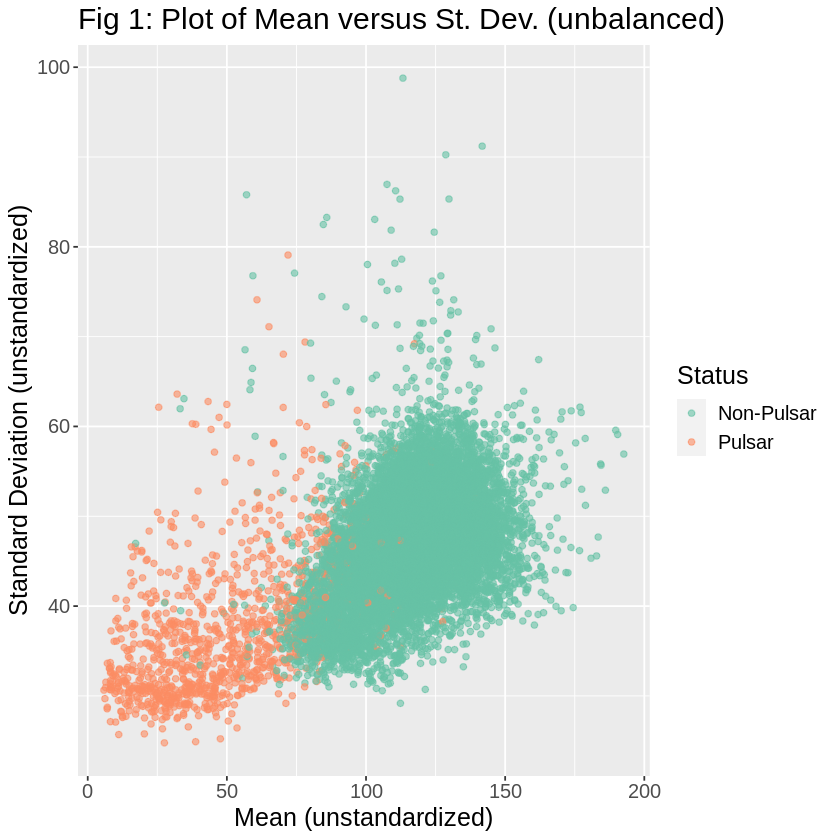

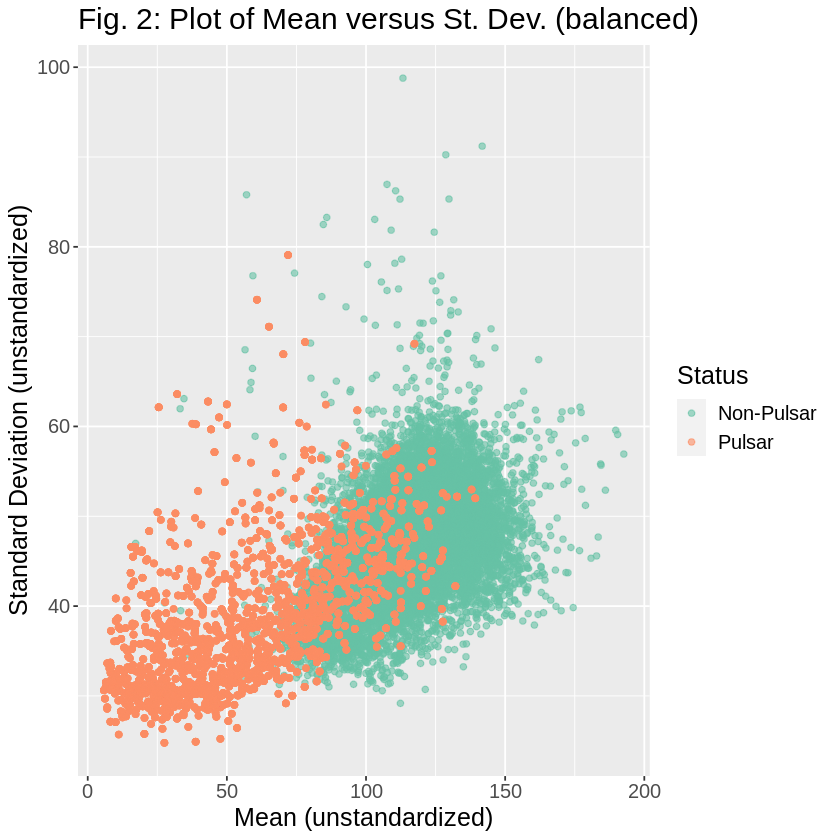

In [168]:
library(gridExtra)

mean_stdev_orig <- data_train |>
  ggplot(aes(x = mean, y = st_dev, color = status)) +
  geom_point(alpha = 0.6) +
  labs(x = "Mean (unstandardized)", 
       y = "Standard Deviation (unstandardized)",
       color = "Status") +
    scale_color_brewer(palette = "Set2", labels = c("Non-Pulsar", "Pulsar")) +
  theme(text = element_text(size = 15)) +
  ggtitle('Fig 1: Plot of Mean versus St. Dev. (unbalanced)')

mean_stdev_bal <- data_balanced |>
  ggplot(aes(x = mean, y = st_dev, color = status)) +
  geom_point(alpha = 0.6) +
  labs(x = "Mean (unstandardized)", 
       y = "Standard Deviation (unstandardized)",
       color = "Status") +
    scale_color_brewer(palette = "Set2", labels = c("Non-Pulsar", "Pulsar")) +
  theme(text = element_text(size = 15))+
  ggtitle('Fig. 2: Plot of Mean versus St. Dev. (balanced)')

mean_stdev_orig
mean_stdev_bal

In [ ]:
## Expected Outcomes and Significance 

#- expect to find - a model with high accuracy?
#- could filter whether or not a certain signal is a pulsar or random radio noise?
#- what makes a pulsar and radio noise different? 